In [1]:
import pandas as pd
import gc
import os
import re
import json
from pathlib import Path
from os.path import join as path_join
import matplotlib.pyplot as plt

In [2]:
train_path = Path("dataset/train.parquet")
eval_path  = Path("dataset/eval.parquet")

nn_train_path = Path("dataset/nn_train.parquet")
nn_test_path = Path("dataset/nn_test.parquet")

In [3]:
keywords_root = Path("keywords")
keywords = []

for tglang_keywords in keywords_root.iterdir():
    tglang = tglang_keywords.name.split(".")[0]
    with open(tglang_keywords) as f:
        keywords += list(map(lambda x: x.strip(), f.readlines()))

keywords = list(set(keywords))
keywords_set = set(keywords)

keywords_set

{'gradient',
 'new',
 'font',
 'caption',
 '_FILE_',
 'request_time',
 'Protocol',
 'backface',
 'nameof',
 'unmanaged',
 'ENV',
 'cite',
 'full',
 'reset',
 'document_root',
 'concept',
 'check',
 'writing',
 'distinct',
 'nginx_version',
 'CONSTRAINT',
 'foreign',
 'ratio',
 '__m128i',
 'arg_',
 'csbyte',
 'date_local',
 'expect',
 'ascending',
 'embed',
 'geoip_area_code',
 'areas',
 'nuint',
 'option',
 'acronym',
 'line',
 'host',
 'tcpinfo_rcv_space',
 'co_await',
 'ins',
 '__sealed',
 'https',
 'upstream_bytes_sent',
 'associativity',
 '@charset',
 'realip_remote_addr',
 'grow',
 'inside',
 'single',
 'position',
 'details',
 'bitor',
 'PRIMARY',
 'culngint',
 'counter',
 'try',
 'rp',
 'lua_gettable',
 'USER',
 'checked',
 '__pin',
 'dynamic',
 'request_uri',
 'update',
 'ssl_early_data',
 'repeat',
 'widows',
 'nullptr',
 'scrollbar',
 'display',
 'dyn',
 'payable',
 'alignof',
 'jwt_claim_',
 'Self',
 '@keyframes',
 'sbyte',
 '__FILE__',
 'h2',
 'covariant',
 'opacity',
 'pro

In [4]:
def load_dataset(path, max_samples_per_class=1000):
    df = pd.read_parquet(path)\
            [["code", "tglang", "target"]]\
            .reset_index()\
            .groupby("tglang")\
            .apply(
                lambda x: x[["target", "code"]].sample(n=min(max_samples_per_class, x.shape[0]), random_state=137)
            )\
            .reset_index()\
            [["code", "tglang", "target"]]
    return df

In [5]:
def my_tokenizer(s):
    single_token_ids  = set([9,10,32,34,39,40,41,44,59,91,93,96,123,125])
    word_ids          = set(list(range(65, 91)) + list(range(97, 123)) + [95])
    number_ids        = set(list(range(48, 58)))
    symbol_ids        = set([33,35,36,37,38,42,43,45,46,47,58,60,61,62,63,64,92,94,95,124,126])
    
    tokens = []
    cache = []
    token_type = 0
    
    for idx, c in enumerate(s):
        id = ord(c)
    
        if id in single_token_ids:

            if len(cache) > 0 and (token_type == 1 or token_type == 2 or token_type == 3):
                tokens.append("".join(cache))
            cache = []
            tokens.append(c)
            token_type = 0

        elif id in word_ids or (token_type == 1 and id in number_ids):

            if token_type == 0:
                cache = [c]
            elif token_type == 1:
                cache.append(c)
            elif token_type == 2:
                tokens.append("".join(cache))
                cache = [c]
            elif token_type == 3:
                tokens.append("".join(cache))
                cache = [c]
            token_type = 1

        elif id in symbol_ids:

            if token_type == 0:
                cache = [c]
            elif token_type == 1:
                tokens.append("".join(cache))
                cache = [c]
            elif token_type == 2:
                cache.append(c)
            elif token_type == 3:
                tokens.append("".join(cache))
                cache = [c]
            token_type = 2

        elif id in number_ids:

            if token_type == 0:
                cache = [c]
            elif token_type == 1:
                tokens.append("".join(cache))
                cache = [c]
            elif token_type == 2:
                tokens.append("".join(cache))
                cache = [c]
            elif token_type == 3:
                cache.append(c)
            token_type = 3

        else:
            if len(cache) > 0 and (token_type == 1 or token_type == 2 or token_type == 3):
                tokens.append("".join(cache))
            cache = []
            token_type = 0

        # print(c, id, cache)

    if len(cache) > 0 and (token_type == 1 or token_type == 2 or token_type == 3):
        tokens.append("".join(cache))

    return tokens

def word2token(word: str):
    if word.isdigit():
        return '0'
    if (word in keywords_set) or re.search(r'[^a-zA-Z0-9_]', word):
        return word
    return ''.join([
        'A' if word[0].isupper() else ('a' if word[0].islower() else '_'),  # startswith 'A', 'a' or '_'
        'a' if any(map(str.islower, word[1:])) else '',
        'A' if any(map(str.isupper, word[1:])) else '',
        '_' if '_' in word else '',
        '2' if len(word) > 10 else ('0' if len(word) == 1 else "1")
    ])

In [6]:
train = load_dataset(train_path, 5000)
eval  = load_dataset(eval_path, 5000)

In [7]:
import math

train = train.sample(frac=1).reset_index(drop=True)
split_index = math.floor(train.shape[0] * 0.8)
print("split_index", split_index)

train_ = train.iloc[:split_index]
move_to_eval_ = train.iloc[split_index:]

train = train_
eval  = pd.concat([move_to_eval_, eval]).reset_index()

split_index 109508


In [8]:
train.shape, eval.shape

((109508, 3), (33336, 4))

In [9]:
def process_code(text):
    return " ".join(list(map(word2token, my_tokenizer(text)))[:4096])

In [10]:
train["code_processed"] = train["code"].apply(lambda row: process_code(row))
eval["code_processed"] = eval["code"].apply(lambda row: process_code(row))

train["code_processed_len"] = train["code_processed"].apply(lambda row: len(row.split()))
eval["code_processed_len"] = train["code_processed"].apply(lambda row: len(row.split()))

train = train[train["code_processed_len"] > 0]
eval = eval[eval["code_processed_len"] > 0]

In [11]:
(
    train["code_processed_len"].min(),
    train["code_processed_len"].max(),
    train["code_processed_len"].mean(),
    train["code_processed_len"].quantile([0.25, 0.50, 0.75, 0.9, 0.95]))

(1,
 4096,
 164.1423923969661,
 0.25     24.25
 0.50     47.00
 0.75    115.00
 0.90    307.00
 0.95    596.00
 Name: code_processed_len, dtype: float64)

In [12]:
train.head(3)

,code,tglang,target,code_processed,code_processed_len
0,&& python3 -m pip install --upgrade pip\\n ...,TGLANG_LANGUAGE_DOCKER,6,&& aa1 - a0 aa1 aa1 -- aa1 aa1 \ \...,63
1,"if let Some(vals) = request.query().all(""foo"")...",TGLANG_LANGUAGE_RUST,21,if let Aa1 ( aa1 ) = request . aa1 ( )...,59
2,-- This source code is licensed under the BSD-...,TGLANG_LANGUAGE_LUA,14,-- Aa1 source code is aa1 aa1 aa...,46


In [13]:
for i, row in train.sample(frac=0.5).reset_index().iterrows():
    print("")
    print("----------------------------", i)
    print("")
    
    print(row["code"])
    print(row["code_processed"])

    if i > 4:
        break


---------------------------- 0

'username': tenhou_query.tenhou_username,
                'rank': tenhou_query.get_rank_display(),
                'date': tenhou_query.username_created_at.strftime('%Y-%m-%d')
' aa1 ' :   aa_2 . aa_2 , 
                                 ' aa1 ' :   aa_2 . aa_2 ( ) , 
                                 ' aa1 ' :   aa_2 . aa_2 . aa1 ( ' % A0 -% a0 -% a0 ' )

---------------------------- 1

{1, 800, 400, 3382, 33382, 3983, 33983},    /* DDR2-400 SC */
	{1, 800, 667, 3354, 33354, 3807, 33807},    /* DDR2-667 SC */
	{1, 800, 800, 3347, 33347, 3763, 33763},    /* DDR2-800 SC */

	{1, 667, 400, 3400, 33400, 4021, 34021},    /* DDR2-400 SC */
	{1, 667, 667, 3372, 33372, 3845, 33845},    /* DDR2-667 SC */
	{1, 667, 800, 3386, 33386, 3822, 33822},    /* DDR2-800 SC */

	{1, 400, 400, 3472, 33472, 4173, 34173},    /* DDR2-400 SC */
	{1, 400, 667, 3443, 33443, 3996, 33996},    /* DDR2-667 SC */
	{1, 400, 800, 3430, 33430, 3946, 33946},    /* DDR2-800 SC */

	{0, 800,

<Axes: >

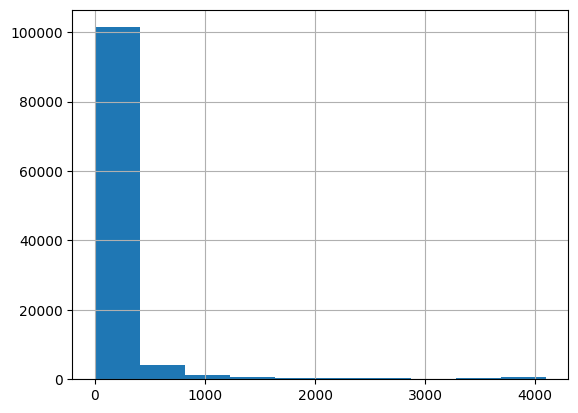

In [14]:
train["code_processed"].apply(lambda row: len(row.split())).hist()

In [15]:
train[["code_processed", "target"]].rename(columns={"code_processed": "code"}).to_parquet(nn_train_path, engine="pyarrow")

In [16]:
eval[["code_processed", "target"]].rename(columns={"code_processed": "code"}).to_parquet(nn_test_path, engine="pyarrow")